### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [104]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


In [51]:
df.shape

(2633, 14)

In [105]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [114]:
df = df[df['media_name'] == 'technologyreview.com']

In [115]:
df.shape

(770, 15)

In [116]:
# Guardar el DataFrame como un archivo CSV
df.to_csv("mit.csv", index=False)


In [117]:
df = pd.read_csv("mit.csv")

In [118]:
df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean
338,d264d2d2a692f7c59574396af68d7b4ba56bfb6b3426da...,2024-02-23 15:20:27.962738,en,technologyreview.com,technologyreview.com,2023-07-31,"The Download: labeling AI, and Twitter’s trans...",https://www.technologyreview.com/2023/07/31/10...,2023,"The Download: labeling AI, and Twitter’s trans...",True,['UK' 'Ukraine' 'UK' 'US' 'China' 'US' 'Taiwan'],['Tate Ryan-Mosley' 'Tate' 'Kanye West’s' 'Elo...,['Twitter' 'The White House' 'EU' 'AI' 'AI' 'C...,"The Download: labeling AI, and Twitter’s trans..."
688,1cb0d251a940933aa6d10a96f677c1937b2a58390c5d01...,2024-09-09 22:10:29.494489,en,technologyreview.com,technologyreview.com,2021-10-19,Getting value from your data shouldn’t be this...,https://www.technologyreview.com/2021/10/19/10...,2021,Sponsored\nGetting value from your data should...,True,['America'],['Sam Altman' 'L. Ron Hubbard'],['Provided byHewlett Packard Enterprise' 'McKi...,Getting value from your data shouldn’t be this...
529,1d0e469a73a882c63a16277259d479a30dbab01892dfd7...,2024-04-30 09:14:47.343401,en,technologyreview.com,technologyreview.com,2022-10-07,"The Download: music-making AI, and Kasparov’s ...",https://www.technologyreview.com/2022/10/07/10...,2022,NaN,False,[],[],[],"The Download: music-making AI, and Kasparov’s ..."


### Clean Data

In [119]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG', 'text_clean'],
      dtype='object')

In [120]:
df.shape

(770, 15)

### Lematization

In [110]:
nlp = spacy.load("en_core_web_sm")

In [121]:
df['text_clean'] = df['title'] + ' ' + df['text'] 

In [122]:
df['text_clean']

0      2024 Innovator of the Year: Shawn Shan builds ...
1      What impact will AI have on video game develop...
2      To be more useful, robots need to become lazie...
3      Roblox is launching a generative AI that build...
4      Integrating security from code to cloud Sponso...
                             ...                        
765                                                  NaN
766                                                  NaN
767    These five AI developments will shape 2021 and...
768                                                  NaN
769    This avocado armchair could be the future of A...
Name: text_clean, Length: 770, dtype: object

In [127]:
# Calcula la cantidad de palabras por fila
df["word_count"] = df["text_clean"].apply(lambda x: len(x.split()))

AttributeError: 'float' object has no attribute 'split'

In [124]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [125]:
# Custom words to remove
words = {'ai', 'say', 'year', 'way', 'use', 'need'}

# Function to parse the text
def parse_document(text):
    """
    Parses the text using spaCy.
    Returns a processed spaCy document.
    """
    return nlp(text)

# Function to clean tokens
def clean_tokens(doc):
    """
    Cleans tokens from the parsed document:
    - Filters tokens by POS tags: PROPN, NOUN, and optionally VERB.
    - Uses lemmatized forms (lemma_) instead of original text.
    - Excludes stopwords, punctuation, and custom-defined words.
    """
    tokens = [
        token.lemma_ for token in doc
        if token.pos_ in {"PROPN", "NOUN", "VERB"}  # Keep specific POS tags
        and token.text.lower() not in STOP_WORDS    # Exclude stopwords
        and token.is_alpha                          # Keep only alphabetic tokens
        and token.text.lower() not in string.punctuation  # Exclude punctuation
        and token.text.lower() not in words         # Exclude custom-defined words
    ]
    return tokens

In [126]:

df['parsed_doc'] = df['text_clean'].apply(parse_document)

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>

In [ ]:
# Calcula la cantidad de palabras por fila
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

In [63]:
df['clean_text'] = df['parsed_doc'].apply(lambda doc: ' '.join(clean_tokens(doc)))

In [16]:
df = df.drop('text_clean', axis=1)

In [17]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...","(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...","(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","(To, be, more, useful, ,, robots, need, to, be...",robot need robot need Smarter datum processing...
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,"[France, Paris]","[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...","(Roblox, is, launching, a, generative, AI, tha...",roblox launch build environment Roblox launch ...
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,"[withMicrosoft, Jiankui]","[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...","(Integrating, security, from, code, to, cloud,...",integrate security code cloud Sponsored Integr...


In [64]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

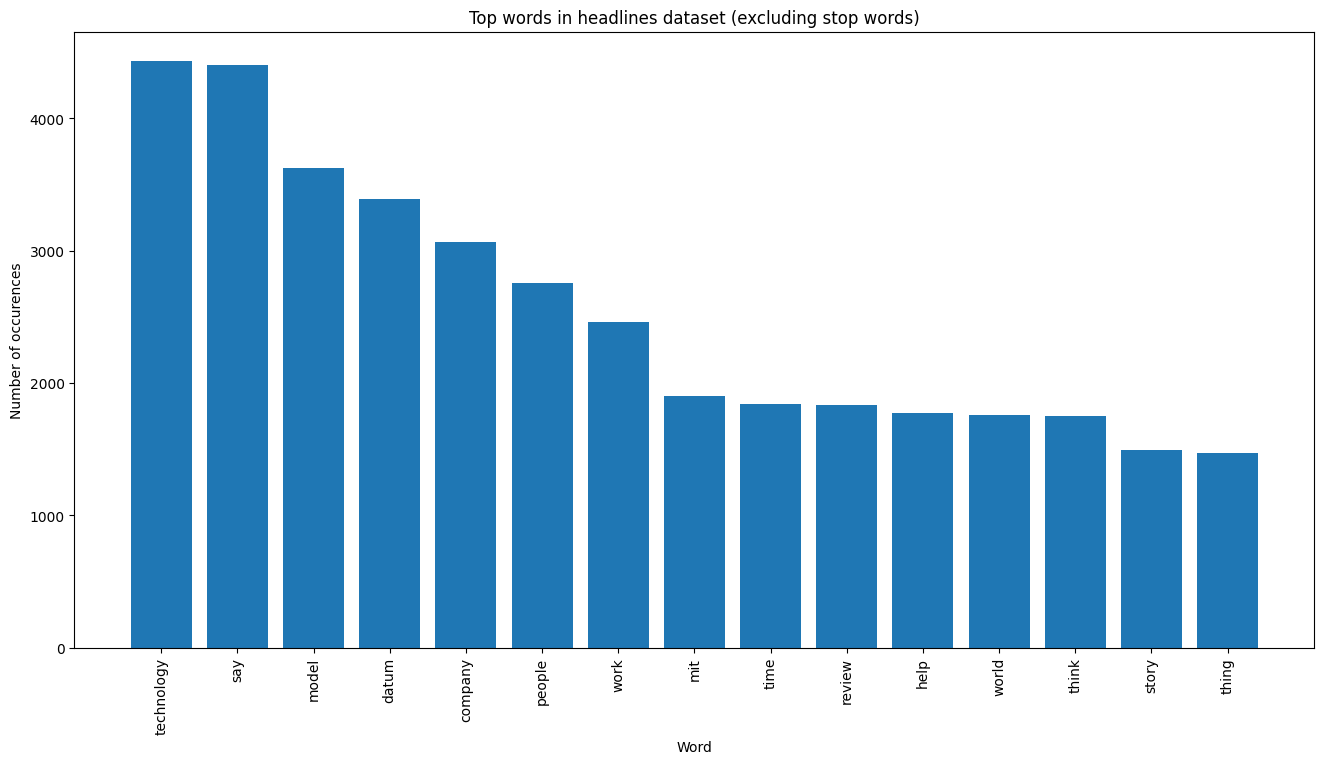

In [65]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [20]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...","(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...","(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","(To, be, more, useful, ,, robots, need, to, be...",robot need robot need Smarter datum processing...
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,"[France, Paris]","[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...","(Roblox, is, launching, a, generative, AI, tha...",roblox launch build environment Roblox launch ...
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,"[withMicrosoft, Jiankui]","[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...","(Integrating, security, from, code, to, cloud,...",integrate security code cloud Sponsored Integr...


### Save clean text

In [21]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [22]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [23]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,impact video game development impact video gam...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",robot need robot need Smarter datum processing...


In [24]:
df.shape

(770, 16)

In [66]:
df['clean_text'].isnull().sum()

np.int64(0)

In [67]:
df = df.dropna(subset=['clean_text'])

### Temperature

In [68]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,parsed_doc,clean_text,temperature,color
2021,0627eb082e04d463097dd76d36d261fccc8de83f0fa202...,2024-07-14 18:35:29.823093,en,technologyreview.com,technologyreview.com,2022-02-28,The AI promise: Put IT on autopilot,https://www.technologyreview.com/2022/02/28/10...,2022,Sponsored\nThe AI promise: Put IT on autopilot...,True,"[Joinville, Brazil, Sora]","[Rafael Cardoso, Cardoso, Cardoso, Mark Esposi...","[AIOps, withHewlett Packard Enterprises, Serco...",The AI promise: Put IT on autopilot Sponsored\...,"(The, AI, promise, :, Put, IT, on, autopilot, ...",promise autopilot Sponsored promise autopilot ...,0,#aa0055
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",What impact will AI have on video game develop...,"(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...,2,#0000ff
2102,50dd8be4c9cc173da4ffb7f94232b3b5218bf92bb84b49...,2024-08-06 00:45:38.494000,en,technologyreview.com,technologyreview.com,2021-12-06,Evolution of intelligent data pipelines,https://www.technologyreview.com/2021/12/06/10...,2021,Sponsored\nEvolution of intelligent data pipel...,True,[],"[AI, Andrew Ng, Andrew Ng\nData, Rube Goldberg]","[byDell Technologies, Kearney, AI / ML, Laggar...",Evolution of intelligent data pipelines Sponso...,"(Evolution, of, intelligent, data, pipelines, ...",Evolution data pipeline Sponsored Evolution da...,-1,#ff0000


In [28]:
df.shape

(769, 18)

In [69]:
df = df.dropna(subset=['year'])
df = df.dropna(subset=['clean_text'])

In [79]:
df.shape

(770, 22)

In [78]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,IND,ORG,text_clean,parsed_doc,clean_text,temperature,color,x,y,word_count
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...",2024 Innovator of the Year: Shawn Shan builds ...,"(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator Shawn Shan build tool help artist fi...,2,#0000ff,714.0,633.0,421
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,...,"[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",What impact will AI have on video game develop...,"(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...,2,#0000ff,407.0,716.0,522
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",...,"[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","To be more useful, robots need to become lazie...","(To, be, more, useful, ,, robots, need, to, be...",robot robot Smarter datum processing machine e...,2,#0000ff,790.0,431.0,708
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,...,"[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...",Roblox is launching a generative AI that build...,"(Roblox, is, launching, a, generative, AI, tha...",roblox launch build environment Roblox launch ...,2,#0000ff,407.0,716.0,368
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,...,"[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...",Integrating security from code to cloud Sponso...,"(Integrating, security, from, code, to, cloud,...",integrate security code cloud Sponsored Integr...,2,#0000ff,535.0,627.0,706


In [80]:
df["word_count"]

0       421
1       522
10      708
14      368
19      706
       ... 
2603      4
2605      3
2616    742
2630      2
2632    508
Name: word_count, Length: 770, dtype: int64

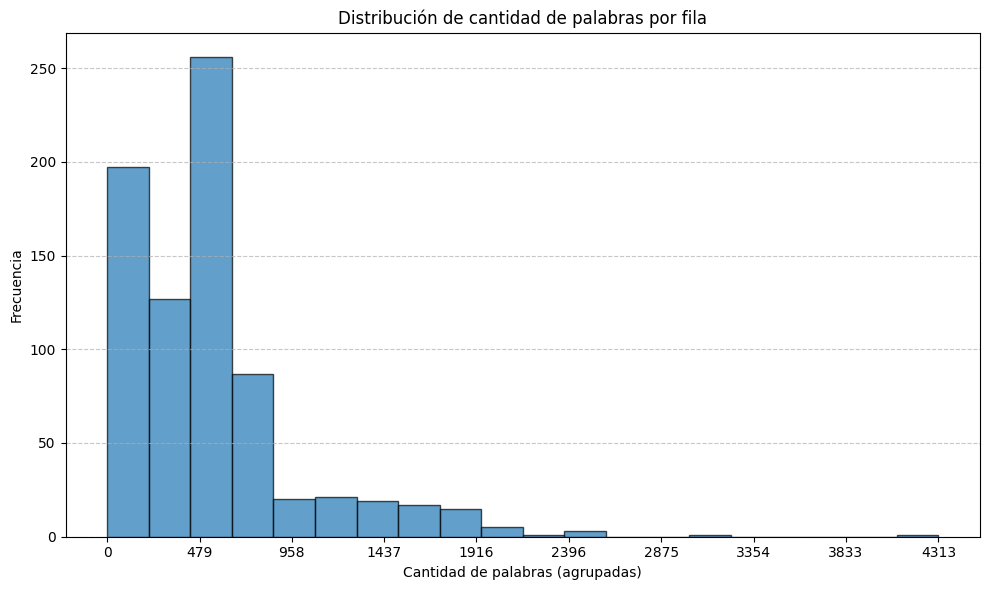

In [76]:
# Genera un histograma con ajustes
plt.figure(figsize=(10, 6))
plt.hist(df["word_count"], bins=20, edgecolor="black", alpha=0.7)  # Ajusta bins a 20 intervalos
plt.title("Distribución de cantidad de palabras por fila")
plt.xlabel("Cantidad de palabras (agrupadas)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Ajuste de ticks en el eje X
plt.xticks(np.linspace(df["word_count"].min(), df["word_count"].max(), 10).astype(int))
plt.tight_layout()
plt.show()

In [90]:
# Filtrar filas donde word_count <= 20
df = df[df["word_count"] >= 10]


### Term Frequency

In [72]:
df["clean_text"]

0       Innovator Shawn Shan build tool help artist fi...
1       impact video game development impact video gam...
10      robot robot Smarter datum processing machine e...
14      roblox launch build environment Roblox launch ...
19      integrate security code cloud Sponsored Integr...
                              ...                        
2603                     Biden administration plan expect
2605                            transform energy industry
2616    development shape Sponsored development shape ...
2630                                       Buddhism ethic
2632    armchair future armchair future OpenAI extend ...
Name: clean_text, Length: 770, dtype: object

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,IND,ORG,text_clean,parsed_doc,clean_text,temperature,color,x,y,word_count
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...",2024 Innovator of the Year: Shawn Shan builds ...,"(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator Shawn Shan build tool help artist fi...,2,#0000ff,714.0,633.0,421
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,...,"[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",What impact will AI have on video game develop...,"(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...,2,#0000ff,407.0,716.0,522
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",...,"[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","To be more useful, robots need to become lazie...","(To, be, more, useful, ,, robots, need, to, be...",robot robot Smarter datum processing machine e...,2,#0000ff,790.0,431.0,708


## UMAP

c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


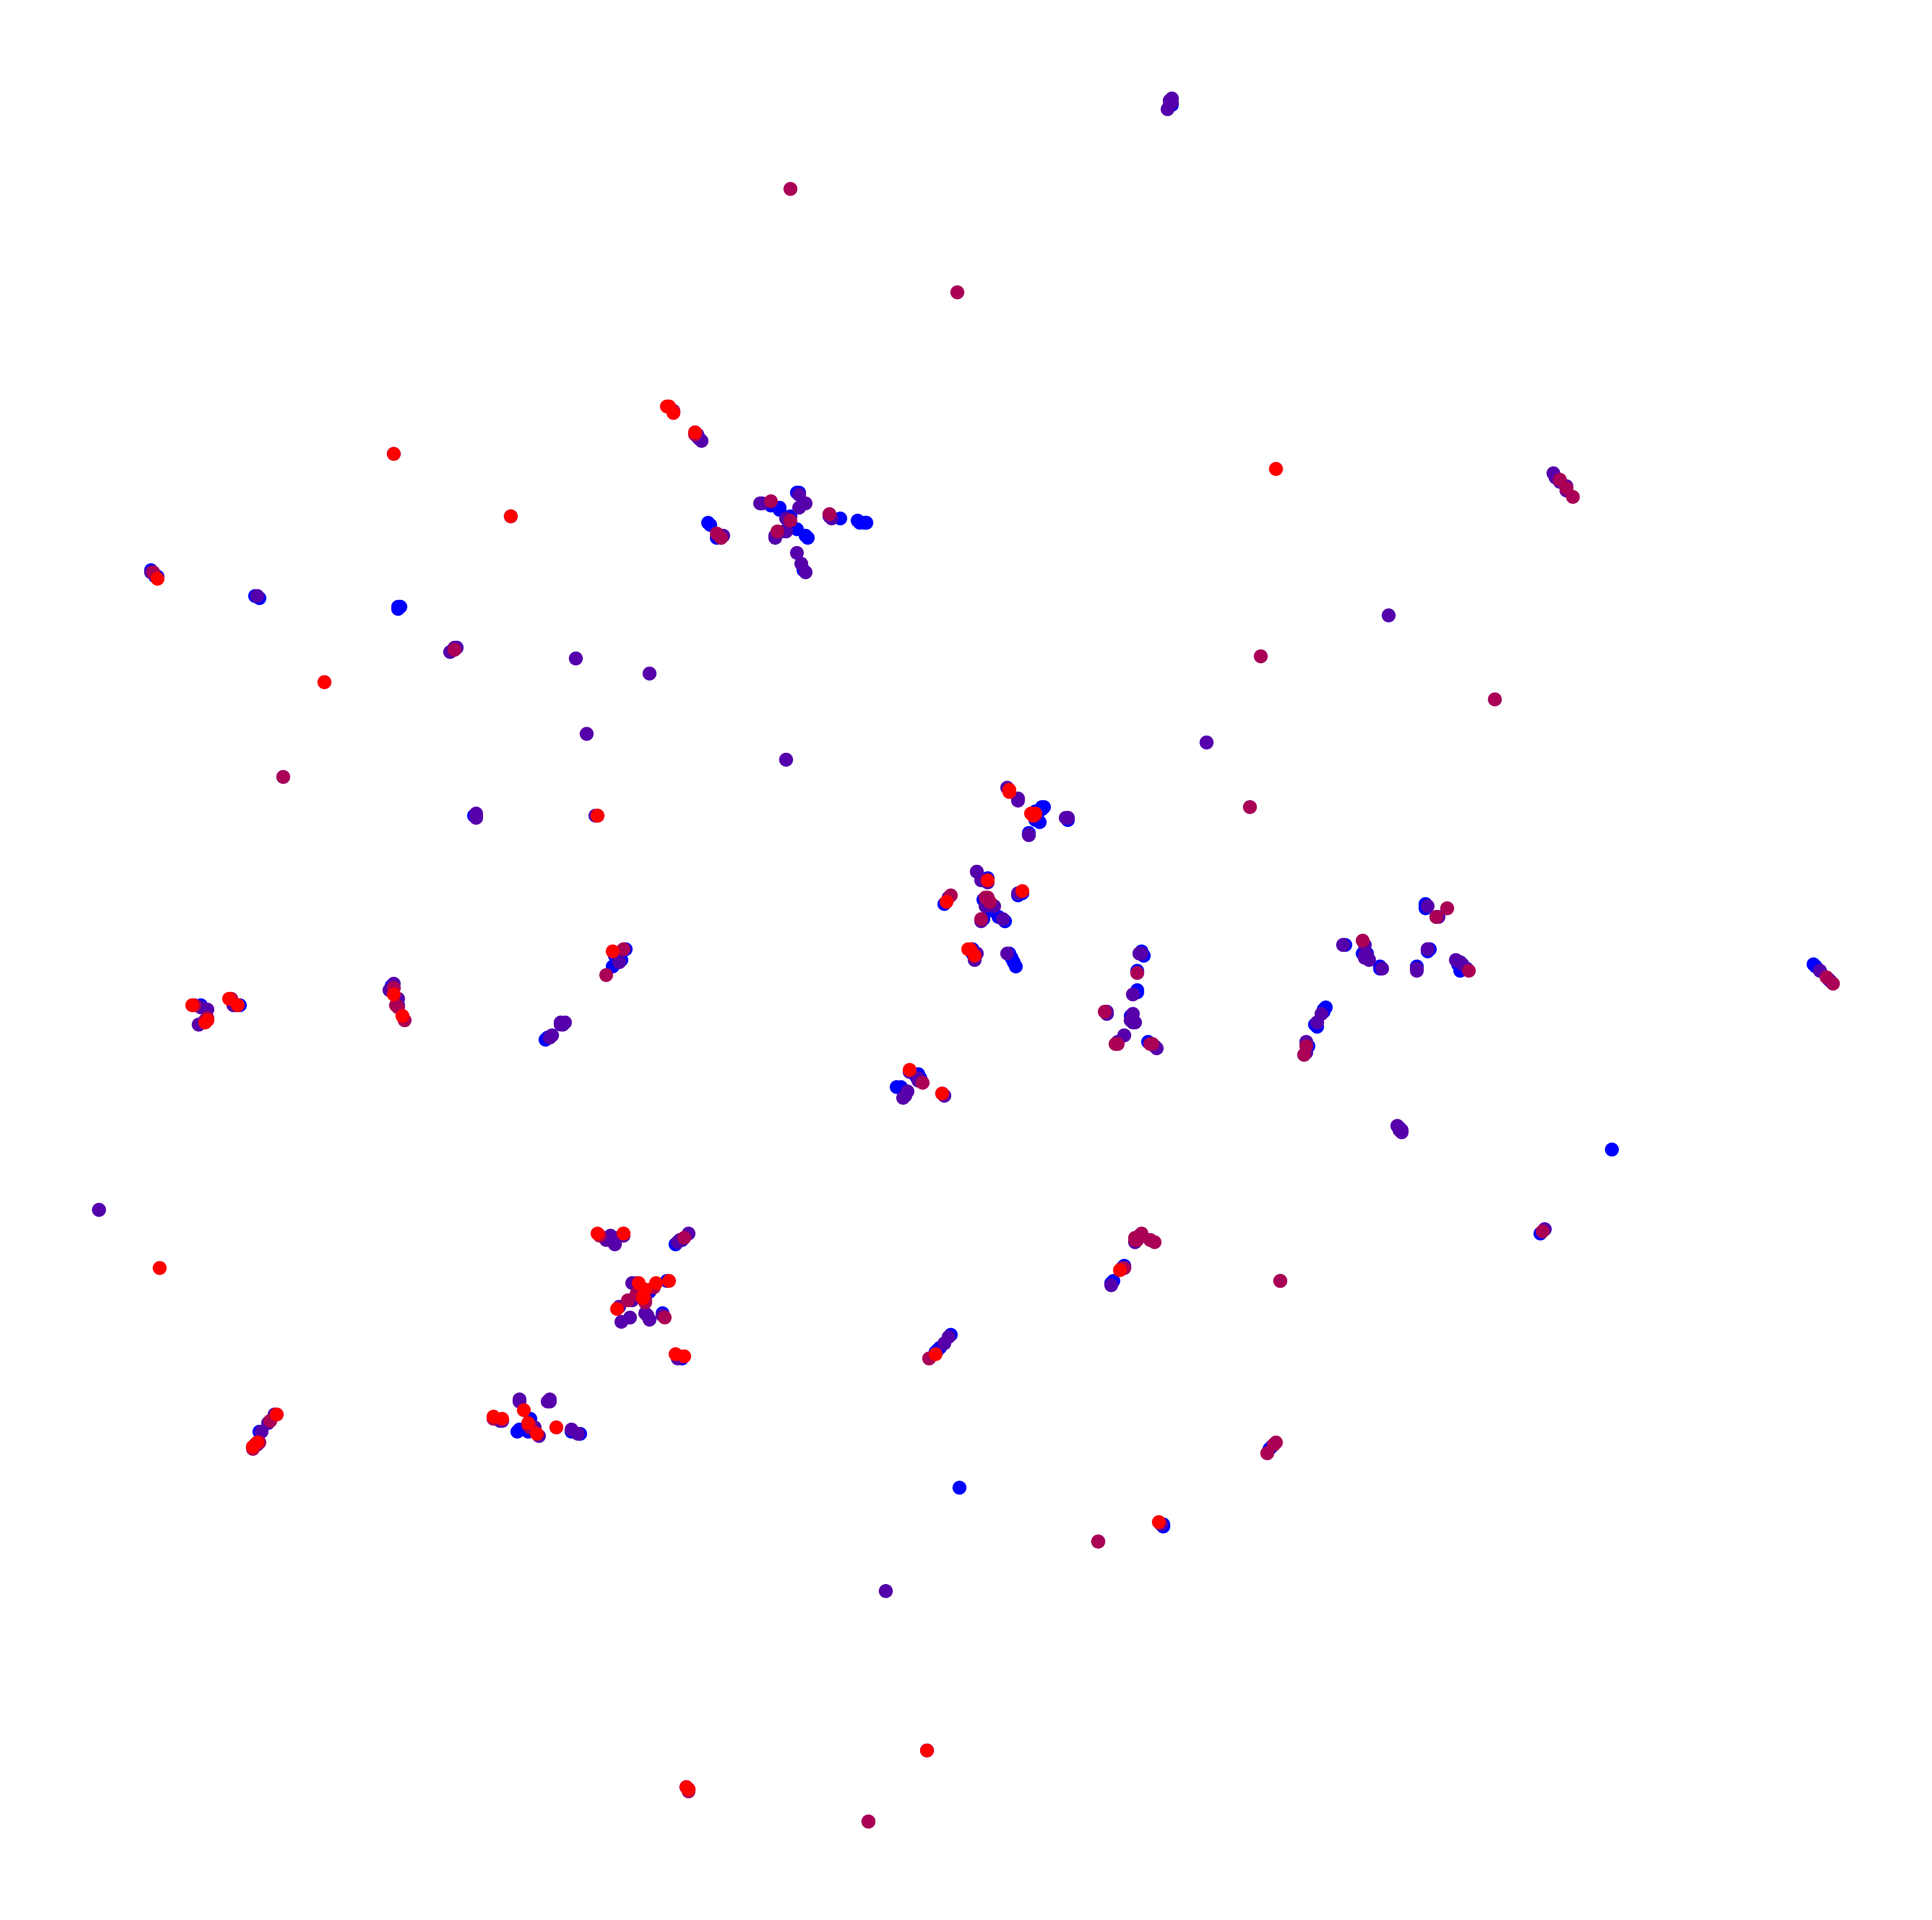

In [92]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")

## Clustering

In [93]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=10,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=10,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    # cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,parsed_doc,clean_text,temperature,color,x,y,word_count,cluster
1484,2089bec33871eaab670a12cab758d63663138263a519df...,2024-03-02 12:32:52.054961,en,technologyreview.com,technologyreview.com,2023-03-16,Chinese tech giant Baidu releases its answer t...,https://www.technologyreview.com/2023/03/16/10...,2023,Chinese tech giant Baidu just released its ans...,...,"[Baidu, ChatGPT, Baidu, Baidu, AI, Baidu, Open...",Chinese tech giant Baidu releases its answer t...,"(Chinese, tech, giant, Baidu, releases, its, a...",tech Baidu release answer tech giant Baidu rel...,1,#5500aa,505.0,541.0,676,p_8
2063,c851d59de3e8f48c164b96001f5726a2641f6ed3fc613b...,2024-06-26 03:51:51.210466,en,technologyreview.com,technologyreview.com,2022-01-19,"Sustainability starts in the design process, a...",https://www.technologyreview.com/2022/01/19/10...,2022,Sponsored\nSustainability starts in the design...,...,"[Autodesk, Autodesk, Autodesk, MIT Technology ...","Sustainability starts in the design process, a...","(Sustainability, starts, in, the, design, proc...",sustainability start design process help Spons...,0,#aa0055,238.0,478.0,1654,n_2
1217,ce176b839776af4fa8f4485ebdff9d8db3026ba8b69e39...,2024-02-25 23:23:51.399968,en,technologyreview.com,technologyreview.com,2023-06-20,Meta’s AI leaders want you to know fears over ...,https://www.technologyreview.com/2023/06/20/10...,2023,Meta’s AI leaders want you to know fears over ...,...,"[Meta, the Signal Foundation, Signal, Google, ...",Meta’s AI leaders want you to know fears over ...,"(Meta, ’s, AI, leaders, want, you, to, know, f...",Meta leader want know fear risk Meta leader wa...,1,#5500aa,657.0,462.0,593,p_11


{'p_2', 'p_11', '-1', 'n_1', 'p_7', 'n_3', 'p_1', 'n_0', 'p_4', 'p_6', 'p_9', 'p_0', 'p_10', 'p_8', 'p_5', 'n_2', 'p_3', 'p_12'}


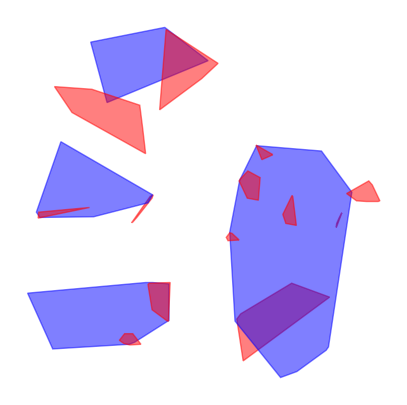

In [94]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [34]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,GPE,IND,ORG,parsed_doc,clean_text,temperature,color,x,y,cluster
470,cb04b6f32650d117dbe9f5514ff3c26f756b598e7b995e...,2024-03-09 11:13:21.042747,en,technologyreview.com,technologyreview.com,2023-01-27,A watermark for chatbots can expose text writt...,https://www.technologyreview.com/2023/01/27/10...,2023,A watermark for chatbots can expose text writt...,...,[],['Tom Goldstein' 'John Kirchenbauer' 'Irene So...,['AI' 'OpenAI' 'ChatGPT' 'CNET' 'ChatGPT' 'the...,A watermark for chatbots can expose text writt...,watermark chatbot expose text write watermark ...,1,#5500aa,320.0,687.0,p_1


# Explorin the clusters

In [96]:
df['cluster'].value_counts()

cluster
-1      131
p_4      57
n_1      51
n_3      41
p_12     40
p_8      34
p_0      33
p_6      27
p_2      24
p_1      22
p_7      20
n_2      19
p_10     19
p_5      17
n_0      15
p_9      14
p_11     13
p_3      13
Name: count, dtype: int64

In [36]:
df['cluster'].nunique()

27

In [37]:
import random

In [98]:
# Filter the headlines belonging to cluster 
cluster_id = 'n_0'
cluster_headlines = df[df['cluster'] == cluster_id]['text_clean']

# Randomly select 10 headlines (or less if there aren't enough) with the seed directly in the same line
random_headlines = random.Random(0).sample(cluster_headlines.tolist(), min(10, len(cluster_headlines)))

# Convert the list of headlines into a string to pass to the API
headlines_text = "\n".join(random_headlines)
print(headlines_text)

Automatic for the robots Automatic for the robots
A computer model inspired by animal anatomy generates and tests hundreds of robot designs.
Robot design is usually a painstaking process, but MIT researchers have developed a system that helps automate the task. Once it’s told which parts you have—such as wheels, joints, and body segments—and what terrain the robot will need to navigate, RoboGrammar is on the case, generating optimized structures and control programs.
To rule out “nonsensical” designs, the researchers developed an animal-inspired “graph grammar”—a set of rules for how parts can be connected, says Allan Zhao, a PhD student in the Computer Science and Artificial Intelligence Laboratory. The rules were particularly informed by the anatomy of arthropods such as insects and lobsters, which all have a central body with a variable number of segments that may have legs attached. (The grammar also allows wheels.)
RoboGrammar can generate thousands of potential structures based o

In [39]:
df['color'].value_counts()

color
#5500aa    262
#0000ff    220
#aa0055    172
#ff0000    115
Name: count, dtype: int64

In [40]:
#Filter by colour

selected_color = '#ff0000'
unique_clusters = df.loc[df['color'] == selected_color, 'cluster'].unique()
if unique_clusters.size > 0:
    print(f"The unique clusters for color {selected_color} are: {list(unique_clusters)}")
else:
    print(f"Color {selected_color} not found in the dataset.")


The unique clusters for color #ff0000 are: ['n_1', 'n_8', 'n_7', 'n_2', 'n_6', 'n_5', '-1', 'n_4', 'n_3', 'n_0']
